In [ ]:
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2


2024-05-09 21:16:17.628280: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25363087360


# 3a Toy Data - Diffusion Curvature
> 2 Manifolds, colored by curvature, neatly compared

Here is the curvature equivalent of the "sniff test": does our technique appropriately color the most basic 2 manifolds? This notebook implements this comparison, making it easy to swap in and out curvature methods and rerun them on every baseline.

In [ ]:
# Establish Datasets
load_from_saved = True
if load_from_saved:
    Xs = np.load("../../results/toy_data_saved_1000.npz")
    Ks = np.load("../../results/toy_datasets_ground_truth_curvatures_1000.npz")
else:
    n_points = 1000
    Xs = {}
    Ks = {}
    Xs['Torus'], Ks['Torus'] = torus(n_points, use_guide_points=False, seed=19323)
    Xs['plane'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
    Ks['plane'] = np.zeros(len(Xs['plane']))
    Xs['Saddle'], Ks['Saddle'] = paraboloid(n_points, use_guide_points=False, seed=19323)
    Xs['Sphere'], Ks['Sphere'] = sphere(n_points,)
    Xs['Ellipsoid'], Ks['Ellipsoid'] = ellipsoid(n_points, seed=19323)
    Xs['Hyperboloid'], Ks['Hyperboloid'] = hyperboloid(n_points, seed=19323)
    # Noised Versions
    for noise_scale in [0.05, 0.1, 0.15, 0.2, 0.25]: #[0.1, 0.2, 0.3, 0.4, 0.5]:
        Xs[f'Torus noise = {noise_scale}'], Ks[f'Torus noise = {noise_scale}'] = torus(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
        # Xs['plane noise = {noise_scale}'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
        # Ks['plane noise = {noise_scale}'] = np.zeros(len(Xs['plane']))
        Xs[f'Saddle noise = {noise_scale}'], Ks[f'Saddle noise = {noise_scale}'] = paraboloid(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
        # Xs['sphere = {noise_scale}'], Ks['sphere = {noise_scale}'] = sphere(n_points,)
        Xs[f'Ellipsoid noise = {noise_scale}'], Ks[f'Ellipsoid noise = {noise_scale}'] = ellipsoid(n_points, seed=19323, noise = noise_scale)
        Xs[f'hyperboloid noise = {noise_scale}'], Ks[f'hyperboloid noise = {noise_scale}'] = hyperboloid(n_points, seed=19323, noise = noise_scale)
    # np.savez(f'../../results/toy_datasets_ground_truth_curvatures.npz', **Ks)

In [ ]:
# save results on toy datasets for later use
# np.savez(f'../../results/toy_datasets_ground_truth_curvatures.npz', **Ks)

In [ ]:
from diffusion_curvature.kernels import gaussian_kernel
def fixed_median_heuristic_graph_former(X, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = None, # use median heuristic
        anisotropic_density_normalization = alpha,
        threshold_for_small_values = 1e-8,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

In [ ]:
# graph_former = partial(fixed_graph_former, sigma = 0.05, alpha = 1)
# graph_former = partial(fixed_median_heuristic_graph_former,alpha=1)


method_name = "entropic_fixed_subtraction"
k = 5
# graph_former = partial(get_fixed_graph, sigma=0.5, alpha=1)
graph_former = partial(get_adaptive_graph, k=k, alpha=1)

DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
# DC = DiffusionCurvature(
#     laziness_method="Entropic",
#     flattening_method="Fixed",
#     comparison_method="Subtraction",
#     graph_former = graph_former,
#     smoothing = 1,
# )
unsigned = False
t = 25



# method_name = "neurips_laziness_no_comparison"
# k = 15
# graph_former = partial(get_adaptive_graph, k=k, alpha=1)
# DC = DiffusionCurvature(
#     laziness_method="Laziness",
#     flattening_method="Fixed",
#     comparison_method="Subtraction",
#     graph_former = graph_former,
#     smoothing=2,
#     aperture = 15, # if using Laziness flattening, this controls the size of neighborhood over which the return probability is averaged.
# )
# unsigned = True
# t = 40
# sign_reversal = -1





# Run on Toy Datasets

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
diffusion_ks = {}

In [ ]:
Xs['Torus']

array([[ 2.16170717, -1.6416007 , -0.69976324],
       [-0.88426536, -0.55761963,  0.29789636],
       [-2.9651432 ,  0.39596009, -0.13037855],
       ...,
       [-1.78027964,  1.10827748, -0.99527821],
       [-1.95458397, -0.74267841,  0.99585769],
       [ 1.29277486, -0.63298829, -0.82810288]])

In [ ]:
torus2, ks_torus2 = torus(1000, use_guide_points=False, seed=19323)

In [ ]:
np.allclose(Xs['Torus'], torus2)

True

2024-05-09 21:18:21,055:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:21,185:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


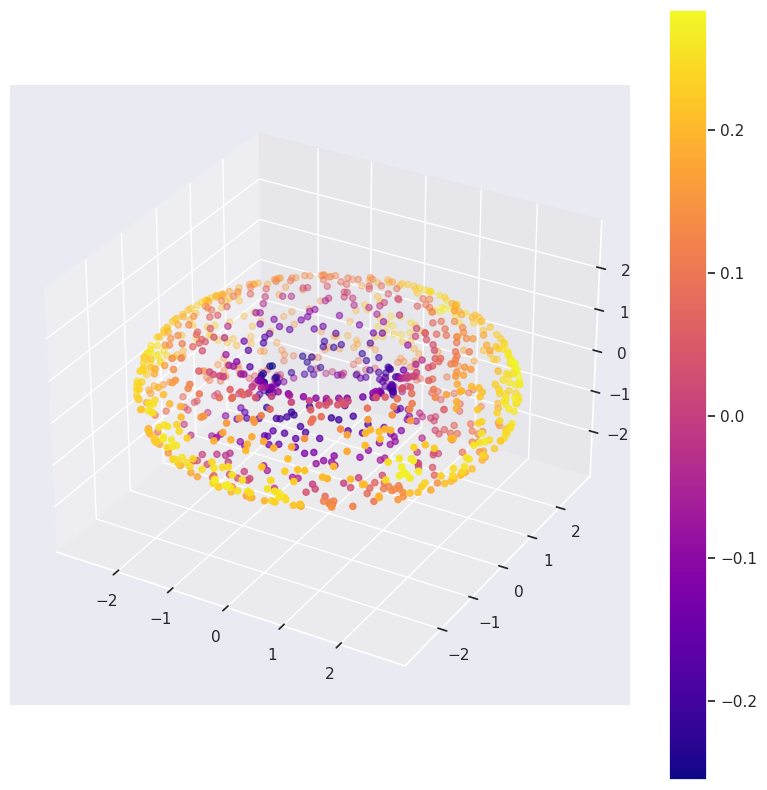

In [ ]:
G_torus = graph_former(torus2)
ks_computed = DC.curvature(G_torus, dim=2, t = 25)
plot_3d(torus2, ks_computed, colorbar=True)

In [ ]:
import copy

2024-05-09 21:18:24,893:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:24,987:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


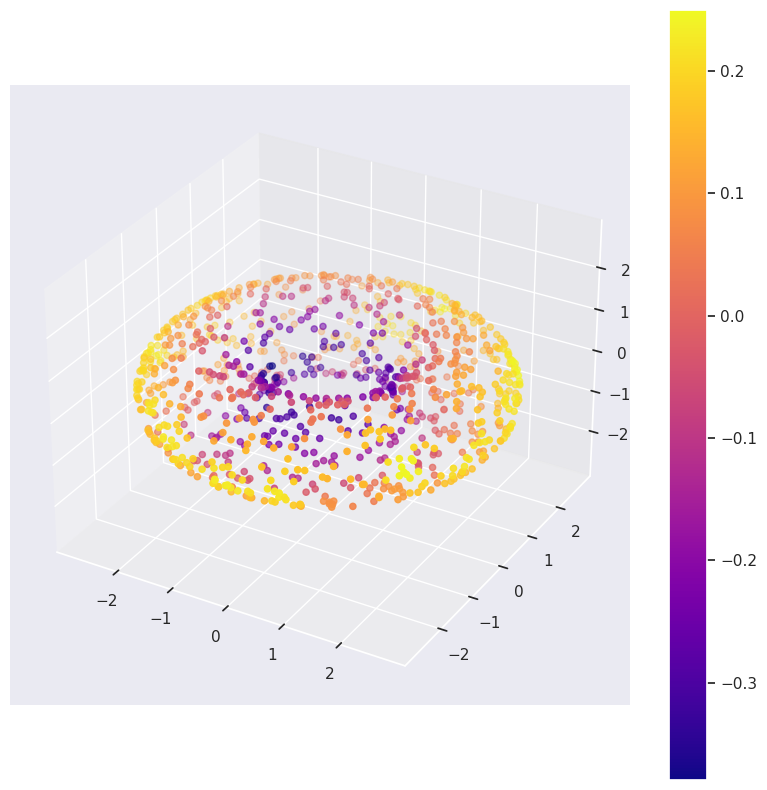

In [ ]:
xtorus_from_file = copy.deepcopy(Xs['Torus'])
G_torus_file = graph_former(xtorus_from_file)
ks_computed_file = DC.curvature(G_torus_file, dim=2, t = 20)
plot_3d(xtorus_from_file, ks_computed_file, colorbar=True)

In [ ]:
G_torus

<pygsp.graphs.graph.Graph>

In [ ]:
G_torus_file

<pygsp.graphs.graph.Graph>

In [ ]:
np.allclose(G_torus_file.W.todense(), G_torus.W.todense())

True

In [ ]:
G_torus.W.todense()

matrix([[7.09085778e-03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.35239569e-04],
        [0.00000000e+00, 7.32278171e-03, 0.00000000e+00, ...,
         0.00000000e+00, 2.78152842e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.01626350e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.19221908e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.78152842e-05, 0.00000000e+00, ...,
         0.00000000e+00, 7.07114647e-03, 0.00000000e+00],
        [1.35239569e-04, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.17920300e-03]])

2024-05-09 21:18:31,410:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:31,529:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


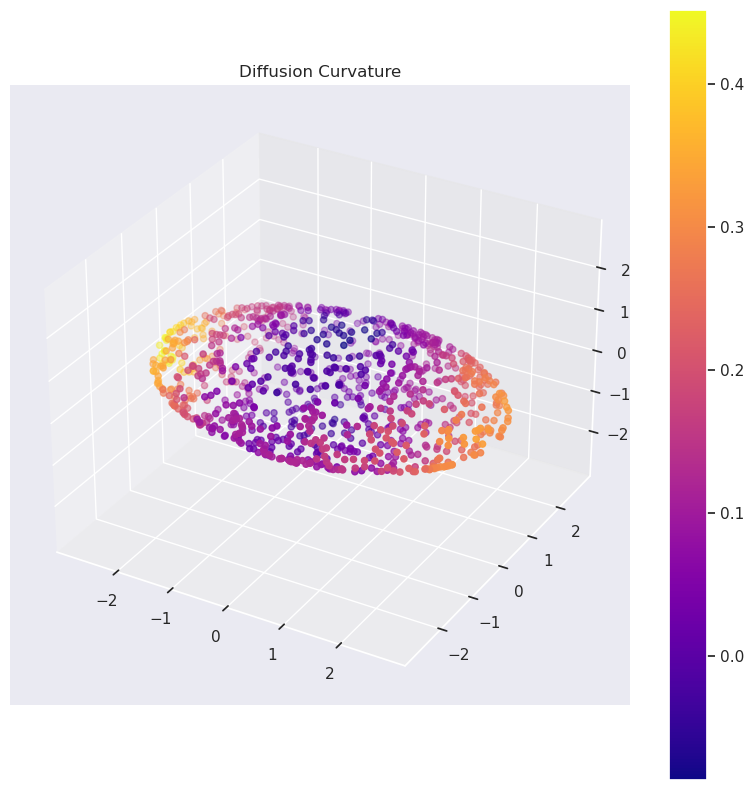

2024-05-09 21:18:31,765:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:31,895:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


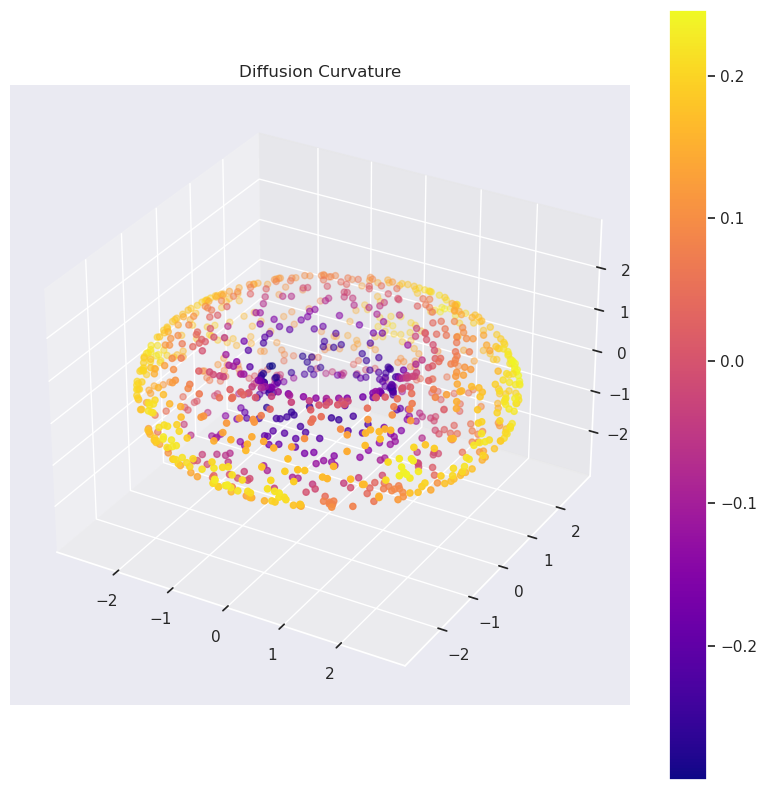

2024-05-09 21:18:32,135:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:32,278:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


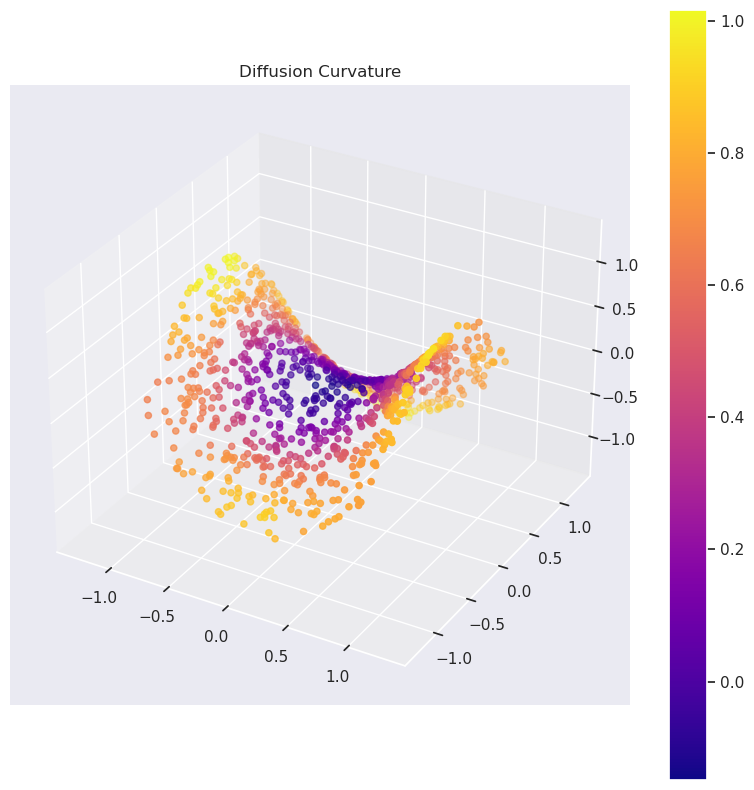

2024-05-09 21:18:32,516:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:32,641:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


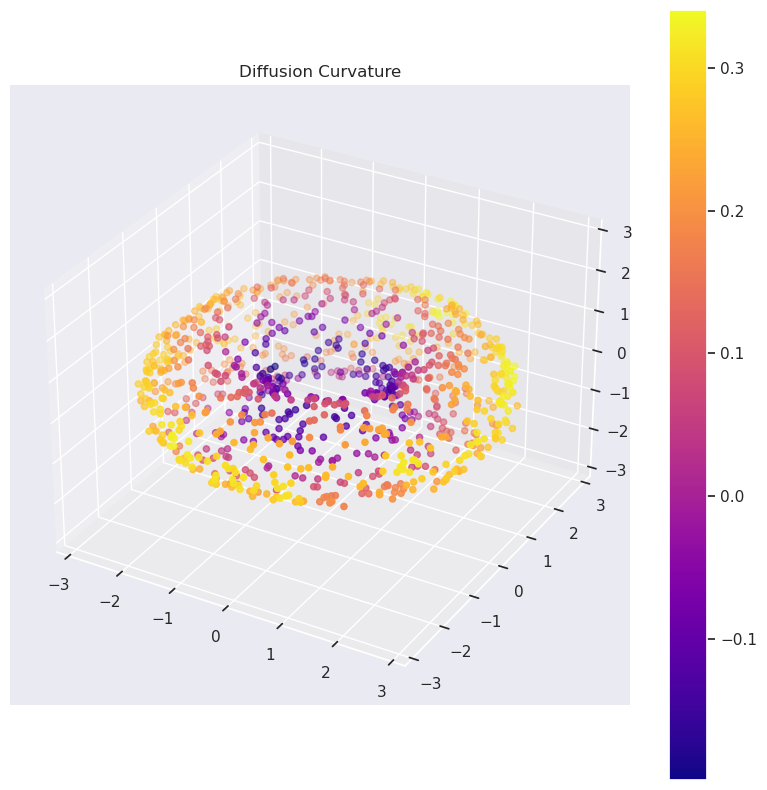

2024-05-09 21:18:32,879:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:32,997:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


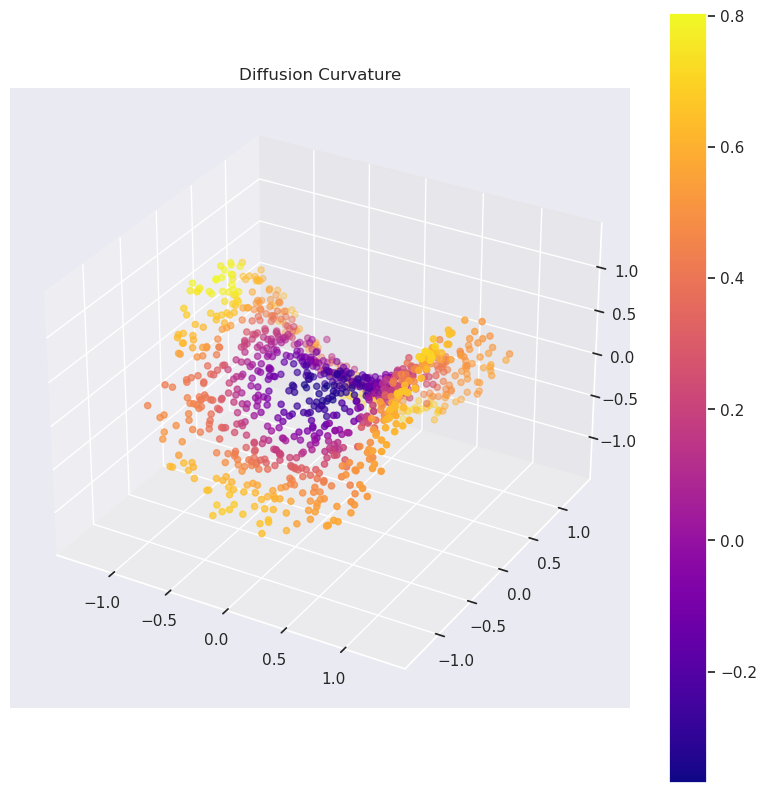

2024-05-09 21:18:33,239:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:33,374:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


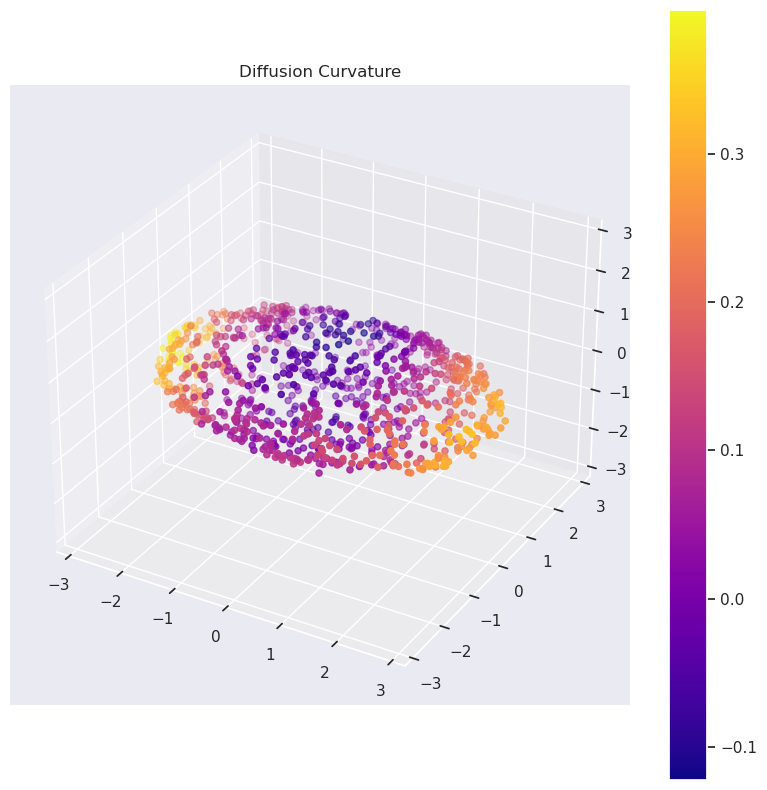

2024-05-09 21:18:33,628:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:33,754:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


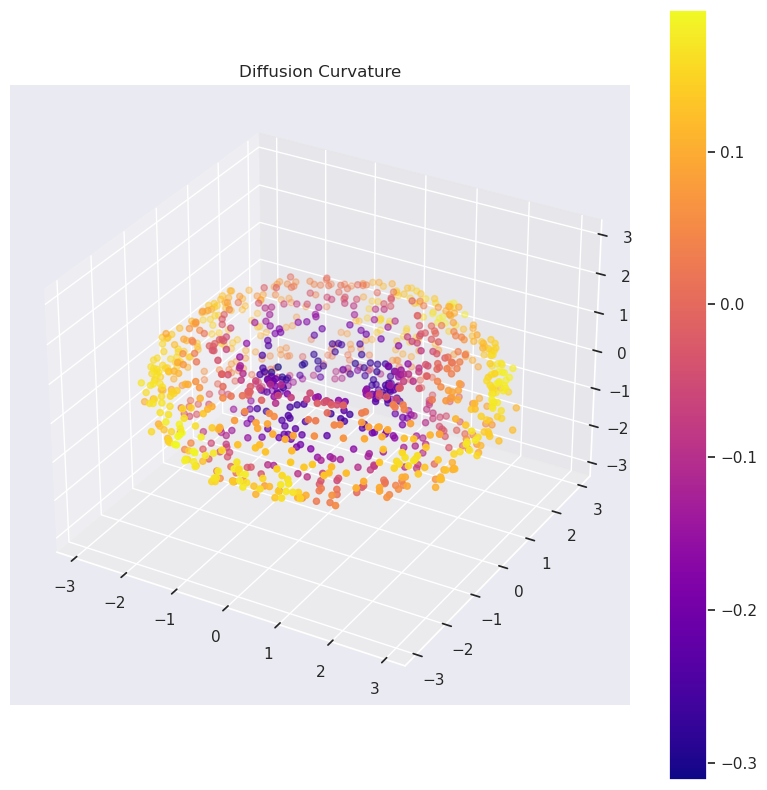

2024-05-09 21:18:34,011:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:34,140:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


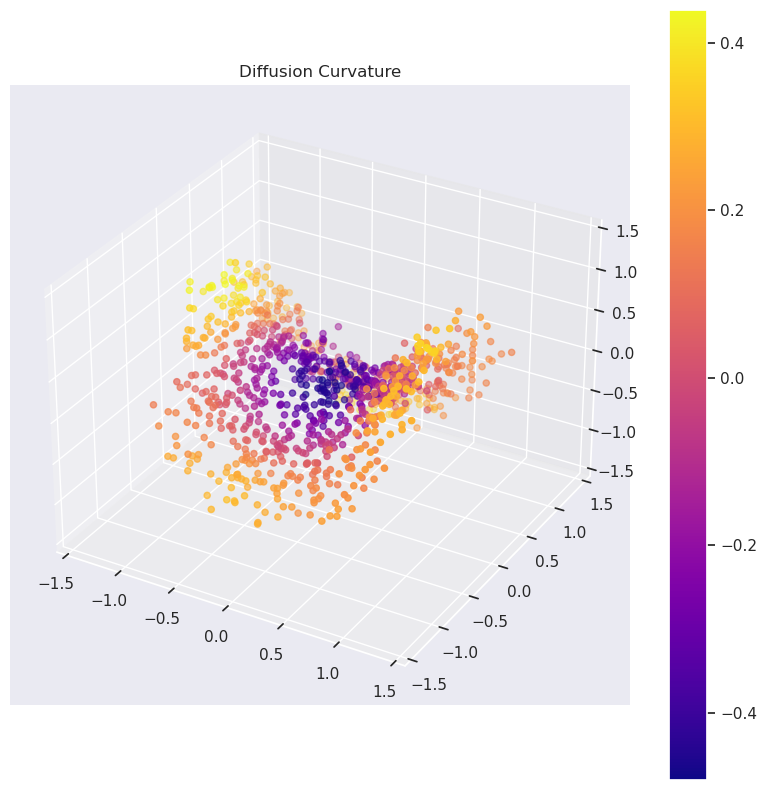

2024-05-09 21:18:34,391:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:34,525:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


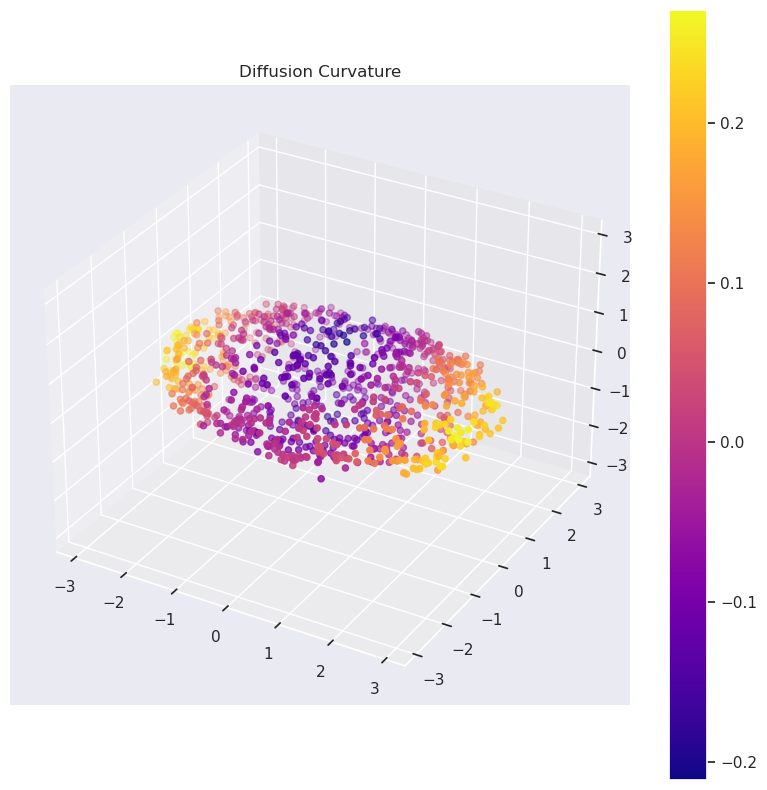

2024-05-09 21:18:34,779:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:34,935:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


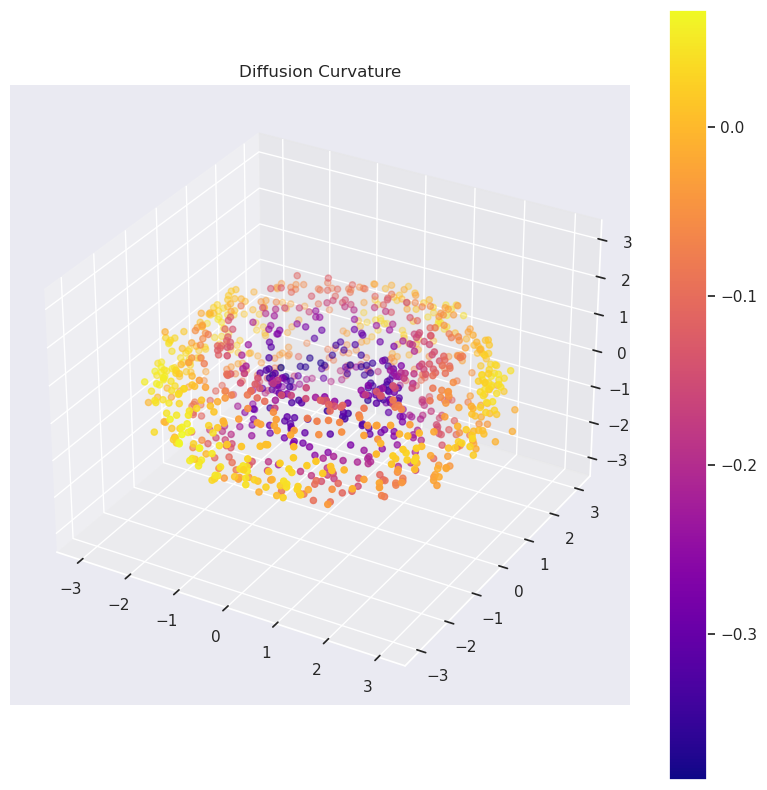

2024-05-09 21:18:35,214:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:35,336:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


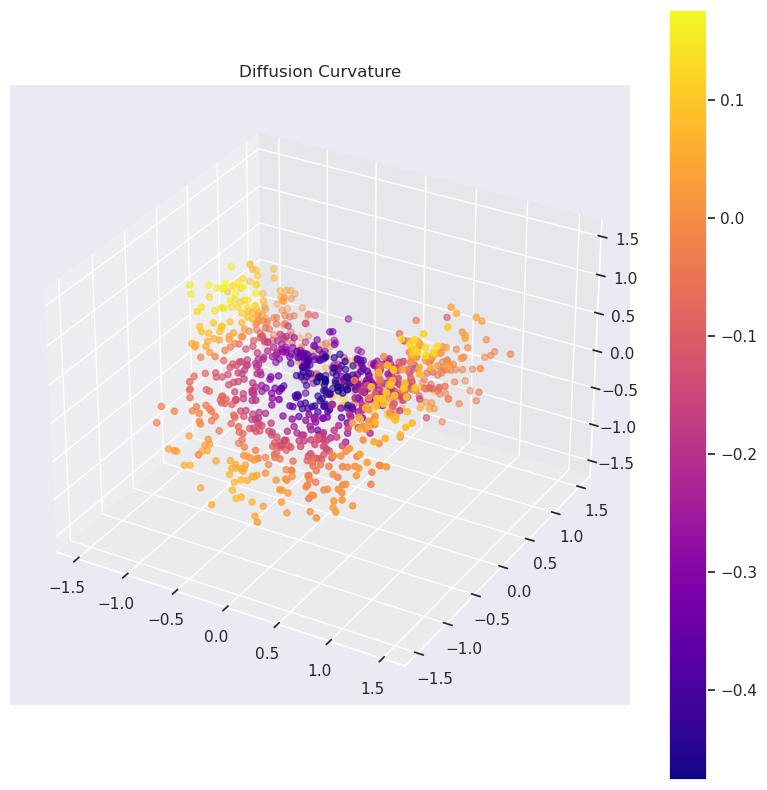

2024-05-09 21:18:35,759:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:35,891:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


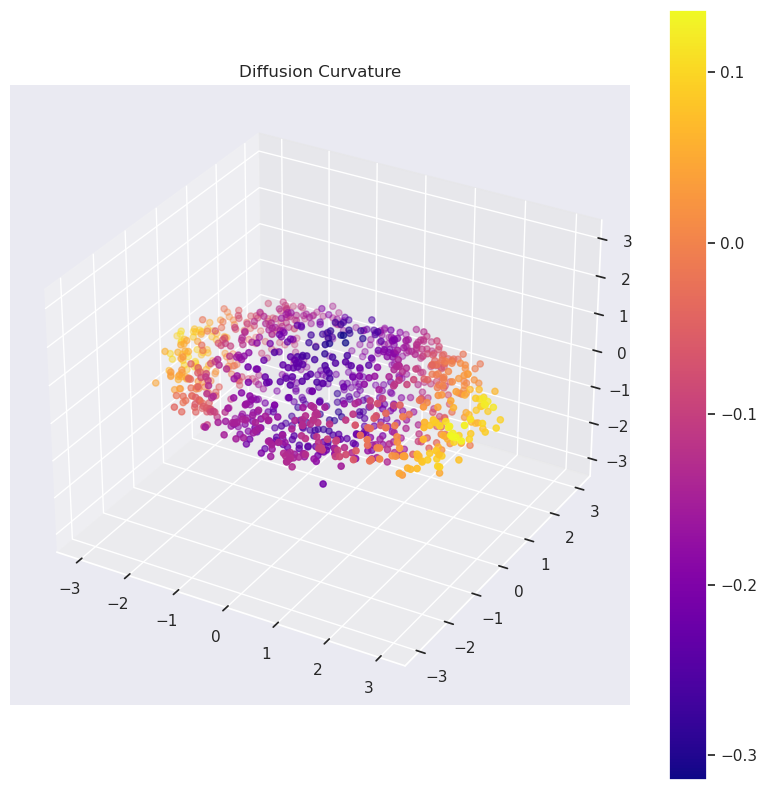

2024-05-09 21:18:36,146:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:36,276:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


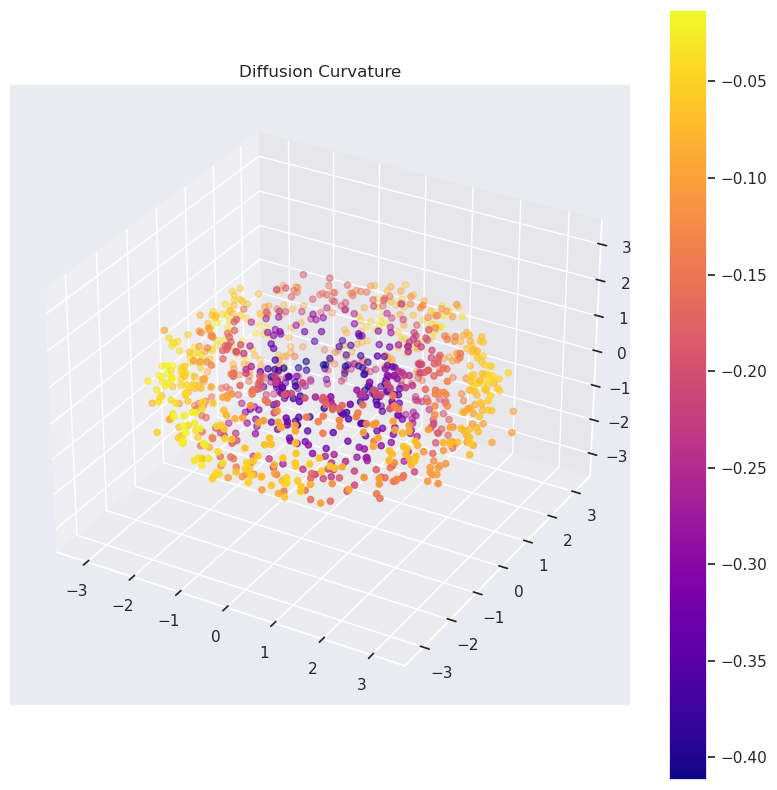

2024-05-09 21:18:36,545:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:36,673:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


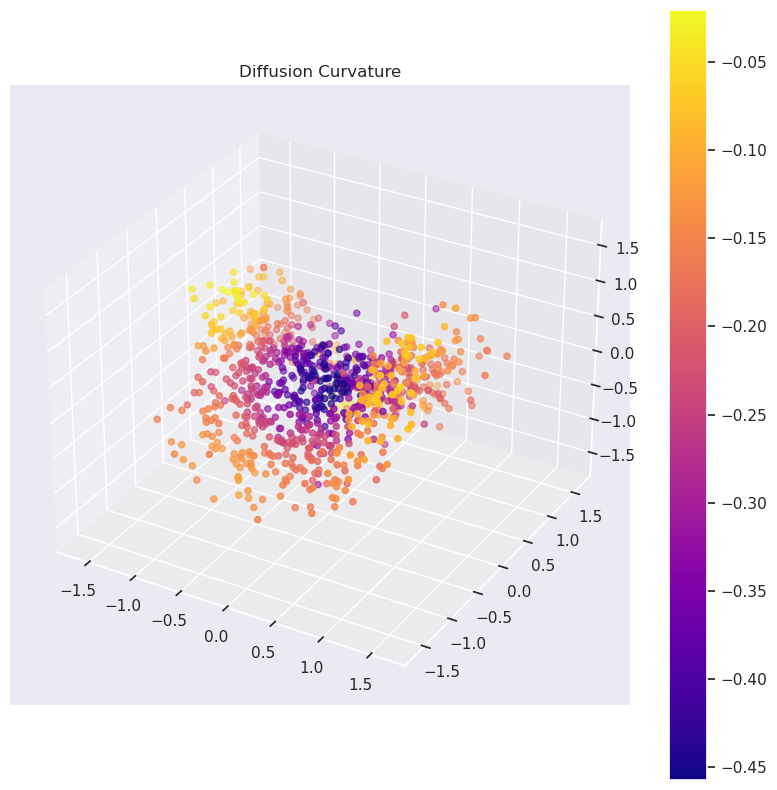

2024-05-09 21:18:36,942:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:37,080:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


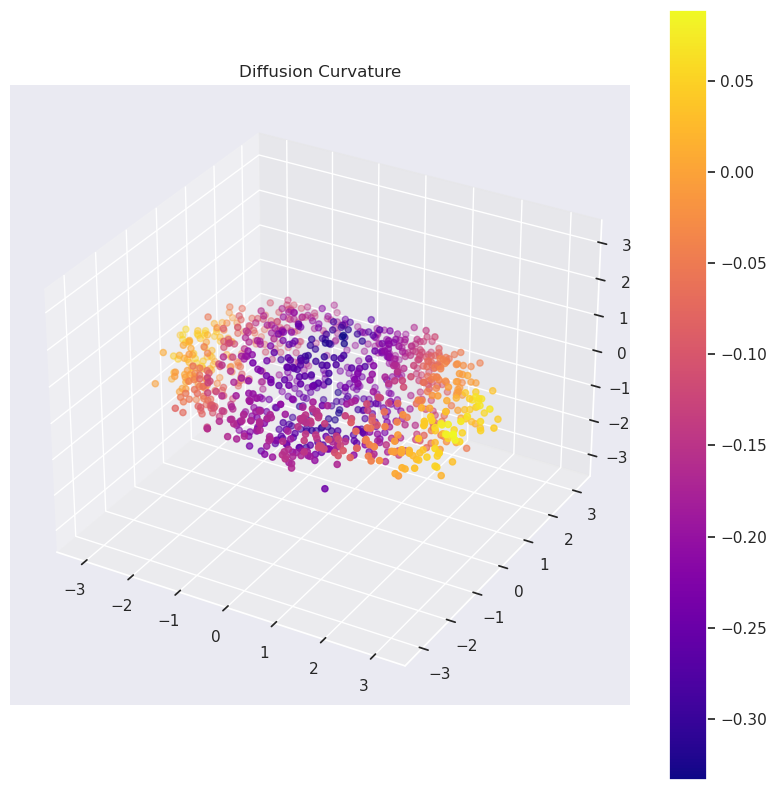

2024-05-09 21:18:37,340:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:37,470:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


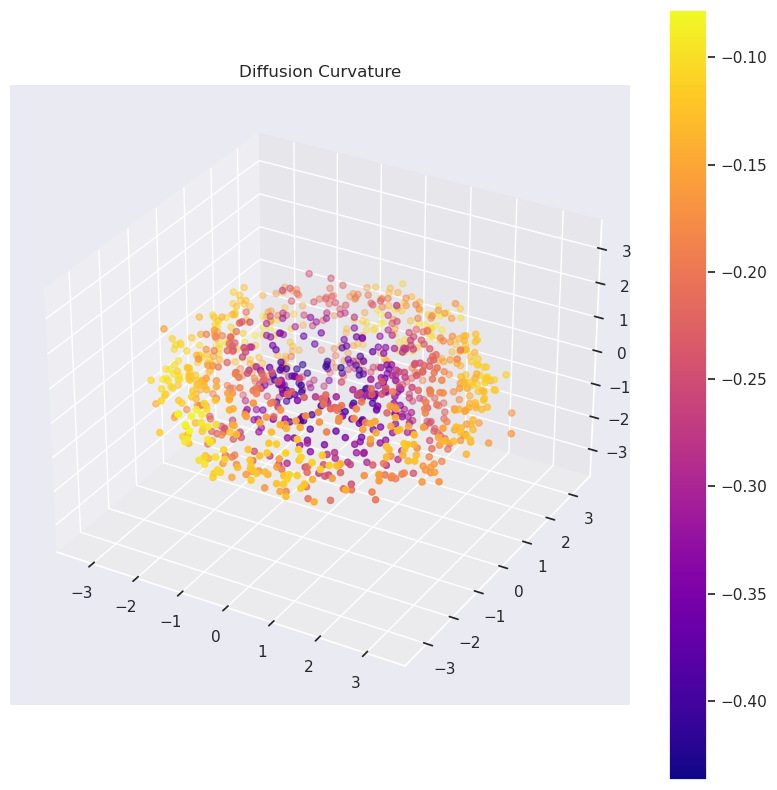

2024-05-09 21:18:37,744:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:37,875:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


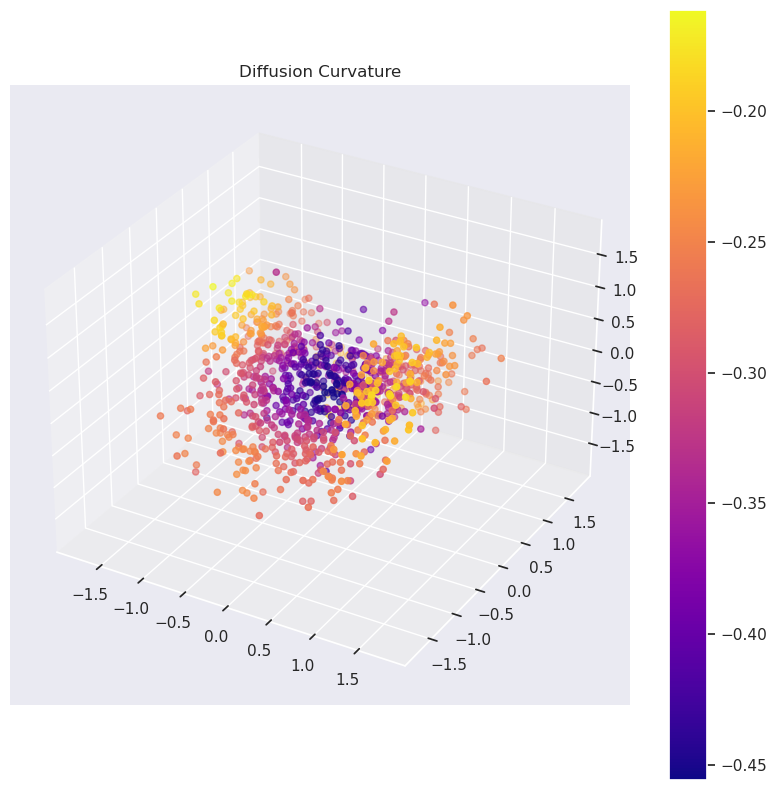

2024-05-09 21:18:38,129:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-09 21:18:38,272:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


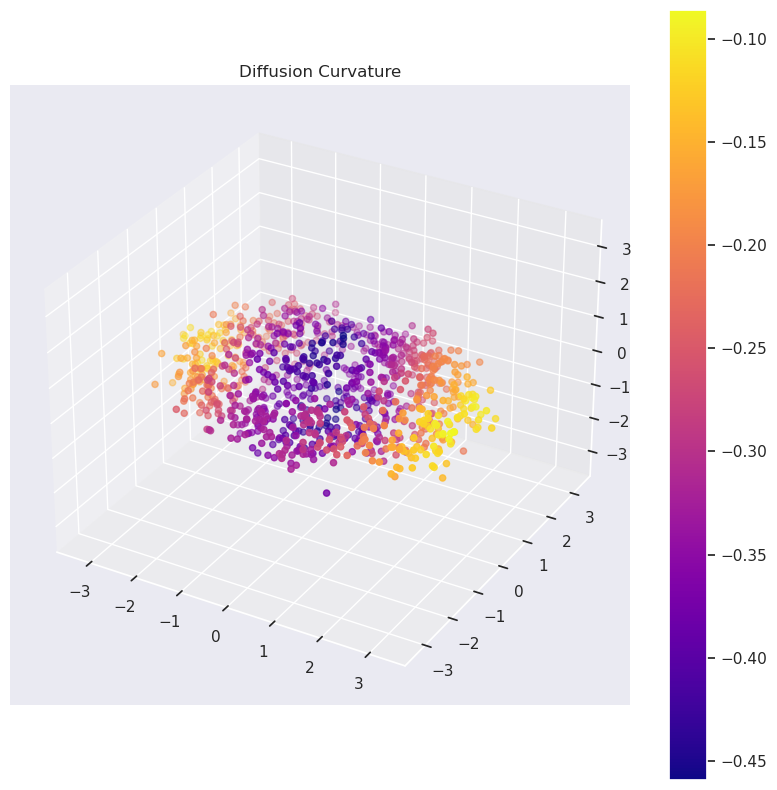

In [ ]:
for dname in Xs.keys():
    X = Xs[dname]
    G = graph_former(X)
    # ks_computed = DC.curvature(G, dim=2, t=25)
    ks_computed = DC.fit_transform(G, t=t, unsigned = unsigned, dim = 2) #* sign_reversal
    # if unsigned:
    #     ks_computed = np.squeeze(scaler.fit_transform(ks_computed[:,None]))
    diffusion_ks[dname] = ks_computed
    plot_3d(X, ks_computed, title = "Diffusion Curvature", colorbar=True)
    # plot_3d(X, Ks[dname], title = "Gaussian Curvature", colorbar=True)


# Figure

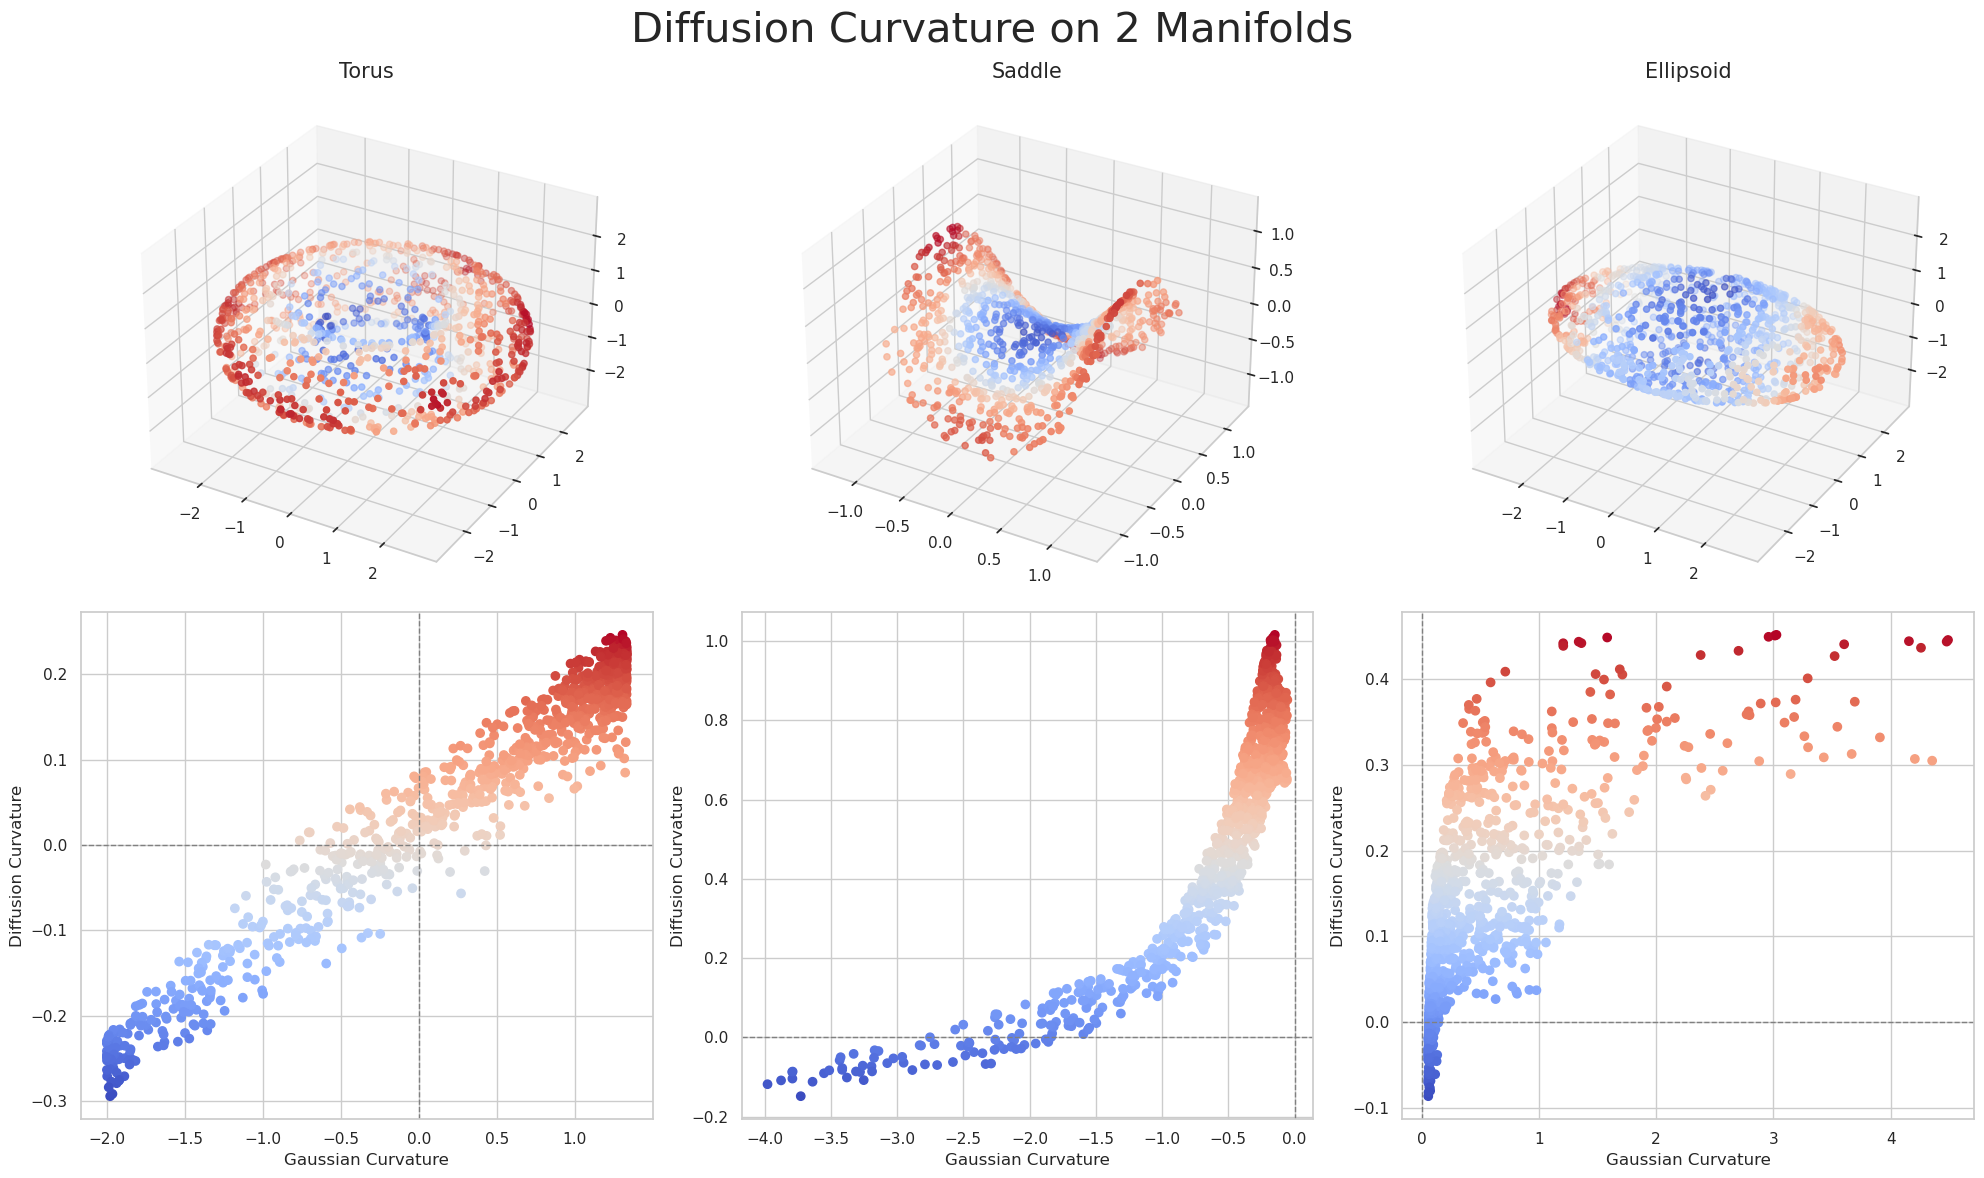

In [ ]:
#| label: fig-2-manifolds
#| fig-cap: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.
#| fig-alt: The Torus, Saddle, Ellipsoid are shown in the first row, colored by the diffusion curvature. The second row shows the scatter plot of the Gaussian curvature vs the diffusion curvature, colored by the diffusion curvature. The origin lines are highlighted in the scatter plots.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = diffusion_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='coolwarm')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='coolwarm')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Diffusion Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Diffusion Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


In [ ]:
ground_truth_labels['Sphere']

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [ ]:
# save results on toy datasets for later use
np.savez(f'../../results/toy_dataset_{method_name}.npz', **diffusion_ks)

# Curvature Across Time

In [ ]:
from diffusion_curvature.comparison_space import *

## With Same parameter fitting

TypeError: DiffusionCurvature.__init__() got an unexpected keyword argument 'use_graphs_kernel_parameters'

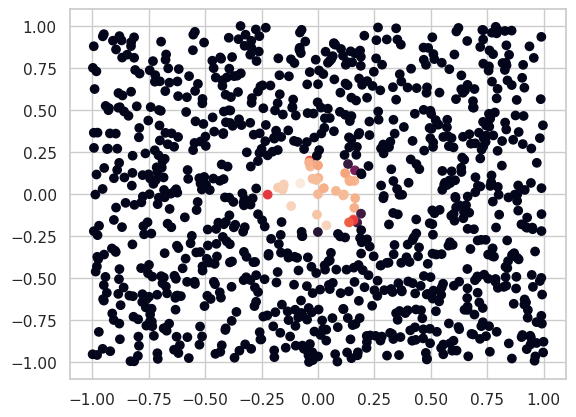

In [ ]:
G_plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_plane,dimension=2)
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
G_flat.get_params()

In [ ]:
G_plane.get_params()

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()

axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to Plane")

plt.show()

In [ ]:
G_plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_plane,dimension=2)
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to plane")

plt.show()

In [ ]:
G_paraboloid = get_alpha_decay_graph(Xs['paraboloid'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_paraboloid,dimension=2)
P = diffusion_matrix_from_affinities(G_paraboloid.K.todense())
plot_3d(Xs['paraboloid'], P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_paraboloid,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Paraboloid")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Paraboloid and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to Paraboloid")

plt.show()

## With Fitted Comparison Space

### Plane

In [ ]:
plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
jump_of_diffusion = DC.unsigned_curvature(G_plane,1)[0]
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)


model = EuclideanComparisonSpace(dimension=2, num_points=len(Xs['plane']), jump_of_diffusion=jump_of_diffusion,)
params = fit_comparison_space_model(model, max_epochs=1000)
print(params)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
W = fill_diagonal(euclidean_stuffs['A'],0)
G_flat = pygsp.graphs.Graph(
    W = W,
    lap_type = G_plane.lap_type, # type of laplacian; we'll use the same as inputted.
    )


uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks)-1)
axs[1].set_xlabel("t")
axs[1].set_ylabel("Ralative ratio (0 is 1)")    
axs[1].set_title("Ratio of Flat to Plane")

plt.show()

### Sphere

In [ ]:
sphere = get_alpha_decay_graph(Xs['sphere'], knn=30, anisotropy=1, )
jump_of_diffusion = DC.unsigned_curvature(sphere,1)[0]
P = diffusion_matrix_from_affinities(sphere.K.todense())
plot_3d(Xs['sphere'], P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)


model = EuclideanComparisonSpace(dimension=2, num_points=len(Xs['sphere']), jump_of_diffusion=jump_of_diffusion,)
params = fit_comparison_space_model(model, max_epochs=1000)
print(params)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
W = fill_diagonal(euclidean_stuffs['A'],0)
G_flat = pygsp.graphs.Graph(
    W = W,
    lap_type = sphere.lap_type, # type of laplacian; we'll use the same as inputted.
    )


uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(sphere,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Sphere")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Sphere and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks)-1)
axs[1].set_xlabel("t")
axs[1].set_ylabel("Ralative ratio (0 is 1)")    
axs[1].set_title("Ratio of Flat to Sphere")

plt.show()

In [ ]:
t = 16
X_torus, ks_torus = torus(2000,use_guide_points=True)
G_torus = graph_former(X_torus)
ksdc, ksn, P, Pt, t = DC.unsigned_curvature(G_torus,t=t, _also_return_first_scale=True)

In [ ]:
plot_3d(X_torus,Pt[0], title=f"t = {t}")